# Exercise Sheet 4 - Segmentation & Denoising with U-Net

 * Deep Learning for Computer Vision - Winter Term 2024/25
 * Lecture by: Constantin Pape
 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
 * Due date: **Tuesday**, Dec 17, before 10:00

In this assignment we will use a U-Net for two different tasks:
- semantic segmentation of nuclei in microscopy images
    - Semantic segmentation is a task in computer vision where the goal is to assign a label or class to every pixel in an image. The result is a segmented image where all pixels with the same label form a region corresponding to a specific object or class. 
- denoising of natural images
    - emoving unwanted noise or distortions from an image to restore its original, clean appearance. Noise in images can arise due to various factors such as low-light conditions, sensor imperfections, or transmission errors.


## Unet
- UNet is a deep learning architecture designed for image segmentation, particularly biomedical image segmentation.
- The network has a symmetric structure with an encoder-decoder design, forming a "U" shape.
    - The encoder (contracting path) captures context by extracting features through successive convolutional and pooling layers.
    - The decoder (expanding path) reconstructs the spatial resolution through upsampling and convolutional layers.
- Skip connections are added between corresponding layers in the encoder and decoder.
- UNet uses only convolutional layers, avoiding fully connected layers. This makes it adaptable to input images of different sizes.
- Designed to work well with limited labeled training data, which is common in biomedical applications.

## Up (transposed) convolution visualized
- https://deeplizard.com/resource/pavq7noze4

## Unet Youtube
- 

## Noise to Noise
- Noise2Noise is a groundbreaking deep learning method for image denoising
-  trains a neural network to restore noisy images without requiring access to clean (noise-free) ground truth images.
-  The network learns to predict the expected value of the clean image given the noisy inputs.
-  By minimizing the difference between two noisy versions of the image, the network implicitly learns to denoise the image.
-  Input and Target: Instead of using a noisy input image and a clean ground truth as a target, Noise2Noise uses two independent noisy versions of the same image: one as the input and the other as the target.
-  Loss Function: During training, the network minimizes the pixel-wise difference (e.g., mean squared error) between the two noisy images. This works because noise is random and uncorrelated between the two images, and the network learns to average out the noise.
-  After training, the network can take a single noisy image as input and output a denoised version, even though it was trained without clean ground truth.
-  

## Hints
The goal of the first part of the exercise (segmentation) is to implement the U-Net architecture very similar to the original publication and then use it for its initial purpose, semantic segmentation. In the second part we will use the same U-Net implementation, but use it for a different task: denoising, following the ideas of noise-to-noise.

To understand the background of this exercise you can:

* Review the lecture (Lecture 5 for U-Net architecture, Lecture 6 for noise-to-noise)
* Read the [U-Net publication](https://arxiv.org/abs/1505.04597).
* Read the [noise-to-noise publication](https://arxiv.org/abs/1803.04189).
* This Exercise consists of 2 parts, make sure to read it till the end

Note that we will implement the same ideas as in these papers, but will deviate from the implementation details and conduct different and fewer experiments.

*Do not hesitate to ask questions and ideally discuss them with the fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck.*

### IMPORTANT SUBMISSION INSTRUCTIONS
- **You need to answer all the questions in written form**
- When you're done, download the notebook from Kaggle and **rename** it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 4` -> `Tutorial <X>`, (where, `X` is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.

**Import required libraries.**

In [2]:
import os
import tqdm
import zipfile
import requests
from glob import glob
from pathlib import Path

import numpy as np
import seaborn as sns
import imageio.v3 as imageio
from matplotlib import colors
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.measure import label
from skimage.util import random_noise
from scipy.optimize import linear_sum_assignment
from skimage.segmentation import find_boundaries, watershed
from skimage.metrics import contingency_table, peak_signal_noise_ratio

In [3]:
# Create a root folder where to save the data for this exercise in Kaggle
root_folder = "/kaggle/working/dlforcv-ex4"
os.makedirs(root_folder, exist_ok=True)

## Segmentation
In the first part of the exercise we will implement the U-Net architecture and apply it to segment nuclei in fluorescence microscopy images. This is an important task in microscopy image analysis in order to identify and characterize cell morphology and dynamics. The data we are using is a subset of the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

### Data preparation

In [4]:
# Download the data
data_folder = os.path.join(root_folder, "kaggle-data")
url = "https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    tmp_path = os.path.join(data_folder, "data.zip")
    with requests.get(url) as r:
        with open(tmp_path, "wb") as f:
            f.write(r.content)

    with zipfile.ZipFile(tmp_path, "r") as f:
        f.extractall(data_folder)

    os.remove(tmp_path)

data_folder = os.path.join(data_folder, "dsb2018")
assert os.path.exists(data_folder)

**Data exploration**

The data is stored in the root folder `dsb2018` and contains the two subfolders `train` and `test` with train/test split. Each of these folders contains the folders `images` with the raw image data and `masks` with the instance masks. As a first step, we will visualize some of the images and labels from the training data.

In [5]:
image_paths = glob(os.path.join(data_folder, "train", "images", "*.tif"))
image_paths.sort()

mask_paths = glob(os.path.join(data_folder, "train", "masks", "*.tif"))
mask_paths.sort()

assert len(image_paths) == len(mask_paths)

In [6]:
# Function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap
    # returns a ListedColormap object,to display the labeled image with distinct random colors for each label

In [7]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)

    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")

    # Visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

### Left: 
- Grayscale images that represent the input images containing nuclei. These are raw images captured from a microscopy setup. The white spots or regions are the nuclei.

### Right: 
- Segmentation masks corresponding to the images in the left column. Each unique color represents a distinct nucleus (or cell). The goal is to assign each nucleus a unique identifier (represented by a unique color in the mask).
- Each unique color represents a distinct nucleus, and the segmentation mask ensures that touching or overlapping nuclei are separated (important for instance segmentation).
-  mask consists of integer values where:
    - Each unique integer corresponds to a distinct nucleus.
    - The background is typically labeled as 0.

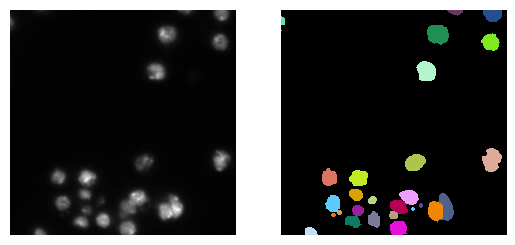

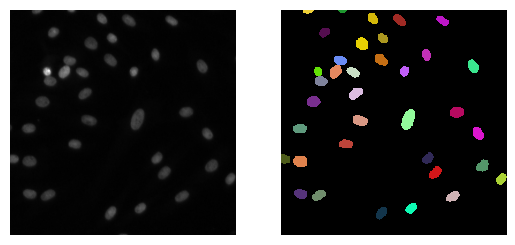

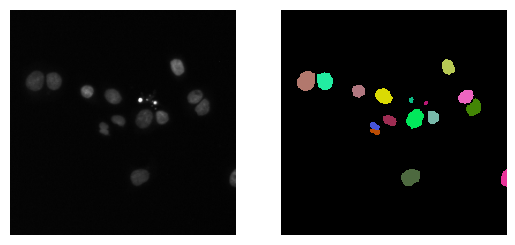

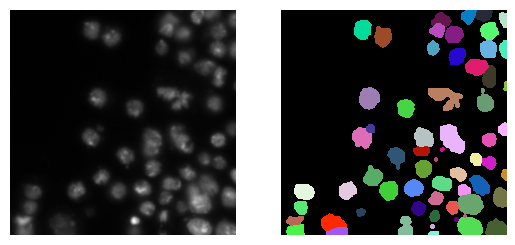

In [7]:
# Plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

You should see 4 images with nuclei and the corresponding colored nuclei masks. To further understand and explain the data, please answer the following **QUESTIONS**:
- Do the ids assigned to the individual nuclei (= colors in the 2nd image column) have a fixed meaning? In other words, would the segmentation meaningfully change if we change shuffle the ids, so that all pixels labeled `1` are labeled `2` and so on?
- Can we directly use a U-Net to predict the mask ids? Why / Why not?

**TODO** your answer here
- The ids/colors assigned to the individual nuclei do not have a fixed meaning. The segmentation would not be affected if we shuffle the ids. The purpose of assigning different colors is to visually distinguish between individual nuclei in the images. The model doesn't rely on the specific values of the ids and it treats each nucleus as a separate entity.

- We cannot directly use a U-Net to predict unique mask IDs because:

    - U-Net is designed for semantic segmentation, not instance segmentation.
    - Predicting unique IDs would require solving the problem of relabeling invariance, which is not feasible for neural networks.
    - Instance segmentation requires additional steps (e.g., connected components, watershed) to distinguish individual objects after the U-Net outputs probability maps or boundaries.
 

The key challenge with directly predicting unique IDs is relabeling invariance: The IDs assigned to individual nuclei are arbitrary (e.g., one model might assign ID 1 to a nucleus, while another might assign ID 2). A neural network cannot learn to output consistent IDs for nuclei without a specific mapping between input and output IDs, which is infeasible in practice.
For example, a U-Net trained to predict "mask IDs" for individual nuclei would need to learn to assign consistent, meaningful IDs to each nucleus, which is not possible because IDs are arbitrary.

To achieve instance segmentation with U-Net, post-processing techniques are required to separate individual nuclei. For example:
- Watershed Algorithm: Separates touching or overlapping objects based on boundaries or distance maps.
- Connected Components: Groups pixels that are spatially connected and belong to the same nucleus.

In [8]:
# TODO find how many images we have in the training set
# and find all (unique) shapes of the images in the training set

# Find the number of images in the training set
num_images = len(image_paths)
print(f"Number of images in the training set: {num_images}")

# Find all unique shapes of the images in the training set
unique_shapes = set()
for path in image_paths:
    image = imageio.imread(path)
    unique_shapes.add(image.shape)

print(f"Number of unique shapes in dataset: {len(unique_shapes)}")
print("Unique shapes of images:")
for shape in unique_shapes:
    print(shape)

Number of images in the training set: 447
Number of unique shapes in dataset: 6
Unique shapes of images:
(512, 640)
(260, 347)
(360, 360)
(520, 696)
(256, 256)
(256, 320)


**QUESTIONS**:
- Do all images have the same shape? If not, can this lead to problems?
- How could we deal with potential problems due to different image shapes?

No, not all images have the same shape. There are six unique shapes in the dataset. 
Having images with different shapes can lead to problems during the training of our neural network, as most deep learning models expect input images to have a consistent shape. In order to assemble images into batches we also need images of the same size.

To deal with potential problems due to different image shapes, you can consider the following approaches:

- resize or crop images to a common size, take patches from bigger images? 
- add padding to the smaller images
- 

In [9]:
# TODO now load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = [imageio.imread(path) for path in image_paths]
masks =  [imageio.imread(path) for path in mask_paths]

In [10]:
ims_flat = np.concatenate([im.ravel() for im in images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
images = [(im.astype("float32") - mean) / std for im in images]

In [11]:
# TODO Make a train validation split, use every 20th image for validation
# Define index for validation set
val_index = 20

# Split images into sets
train_images = [im for i, im in enumerate(images) if i % val_index != 0]
train_masks = [mask for i, mask in enumerate(masks) if i % val_index != 0]
val_images = images[::val_index] # selects every 20th element if val_index = 20
val_masks = masks[::val_index]

print(len(train_images))
print(len(train_masks))

print(len(val_images))
print(len(val_masks))

424
424
23
23


In [12]:
# Finally, let's choose the appropriate torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Implement PyTorch dataset**

As a next step, we implement a `torch.utils.data.Dataset` to access the data for training. As you should have realized in the previous question, the images in our training set come in different sizes. But in order to assemble images into batches we need images of the same size. To solve this issue, we will subsample patches of size 256 x 256 (smallest image size) from the images in the dataset.

In [13]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # Crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]

        # Apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        if self.transform is not None:
            image, mask = self.transform(image, mask)

        # Make sure we have numpy arrays and add a channel dimension for the image data
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]

        return image, mask

    def __len__(self):
        return len(self.images)

As discussed in the lecture, we can't learn the instance segmentation directly. So we will first start with a semantic segmentation problem and train the U-Net to distinguish foreground (nucleus) from background pixels. In other words, the network should predict for each pixel whether it belongs to a nucleus or to the background. To this end, implement a `mask_transform` that converts the instance segmentation ground-truth into a binary target and pass it to the training dataset.

In [14]:
# TODO implement a transform that outputs the binary target 
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target
# HINT: the targets need to be "float32" values (for the BCE Loss coming ahead)

def mask_transform(mask):
    # Binarize the mask: set all non-background pixels to 1
    # cast to np.float32, which is required by the loss function (Binary Cross-Entropy Loss, or BCE Loss).
    binary_mask = (mask > 0).astype(np.float32)
    
    # Add channel dimension
    # binary_mask[None] transforms it into a 3D array with shape [1, H, W], where:
        # 1 represents the channel dimension (for grayscale or binary images, there is only 1 channel).
        # H and W are the height and width of the mask.
    binary_mask = binary_mask[None]
    
    return binary_mask
    

train_dataset = NucleiDataset(train_images, train_masks, mask_transform = mask_transform)
val_dataset =  NucleiDataset(val_images, val_masks, mask_transform = mask_transform)

Sample from training-set:


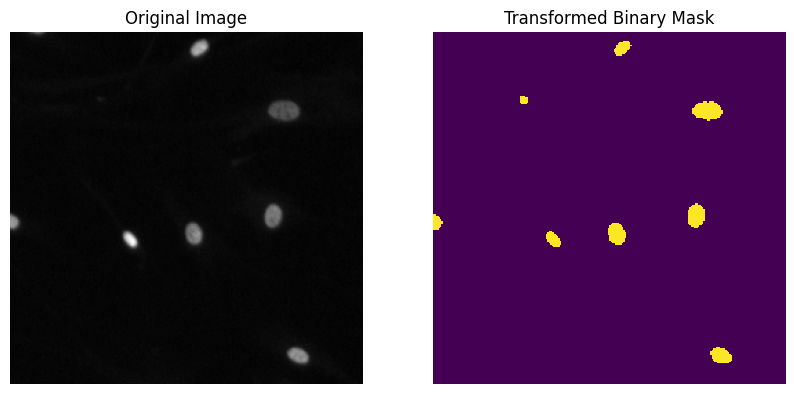

Sample from validation-set:


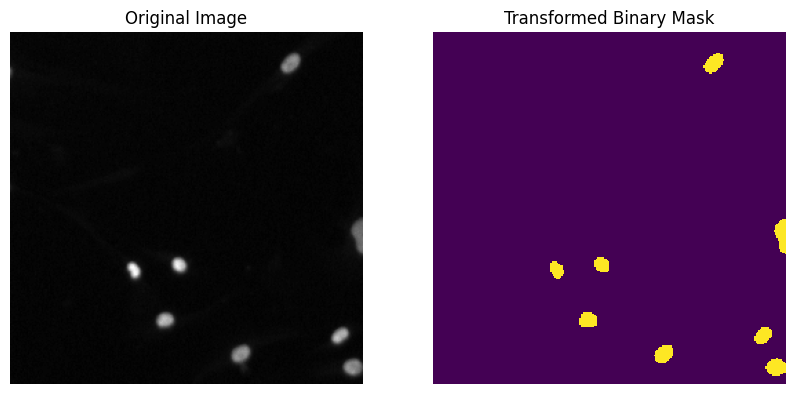

In [15]:
# TODO Sample a few images from the dataset and verify that they are correct

import random
import matplotlib.pyplot as plt

# Function to visualize a single sample with custom colormap
def visualize_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # Plot original image and transformed binary mask with custom colormap
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    transformed_mask = dataset.mask_transform(mask)
    
    axes[1].imshow(transformed_mask.squeeze(), interpolation = 'none')
    axes[1].set_title('Transformed Binary Mask')
    axes[1].axis('off')

    plt.show()

# Visualize a sample from the training dataset
print("Sample from training-set:")
visualize_sample(train_dataset)

# Visualize a sample from the validation dataset
print("Sample from validation-set:")
visualize_sample(val_dataset)

The images you sample should look similar to this (using the standard colormap for the binarized mask):

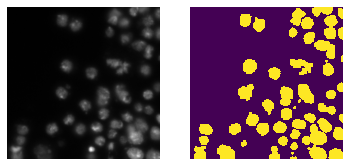

### Implement the U-Net

Next, we will implement a U-Net architecture inspired [Ronneberger et al.](https://arxiv.org/abs/1505.04597), see the image below.

IMPORTANT: unlike in the publication / image we will use SAME convolutions, so that the input shape is the same as the output shape. This will introduce some boundary artifacts, but it will make implementing the rest of this exercise much simpler.

It also means that you don't need to crop the features passed on in the skip connections and can directly concatenate them.

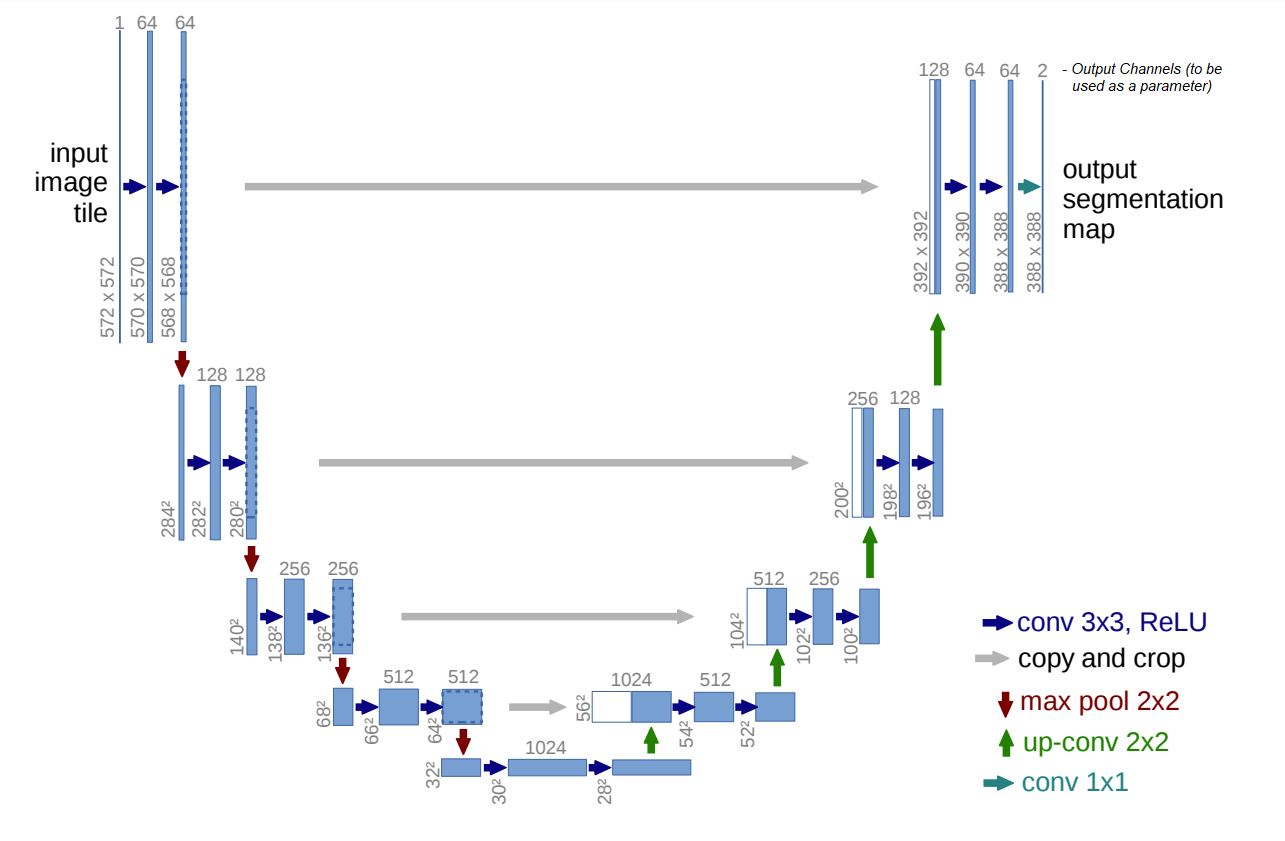

HINTS:
- the `up-conv` used here is called [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#convtranspose2d) in PyTorch.
- you can concatenate the features coming from the skip connections and the encoder with `torch.cat`
- you will need `nn.ModuleList` to store the individual blocks of the encoder / decoder

Before you implement the U-Net, please answer the following QUESTIONS:
- What kind of architecture is the U-Net and what is the rationale behind this architecture?
- What other types of architectures for semantic segmentation exist to achieve similar effects?
- Why are the skip connections used in the U-Net?
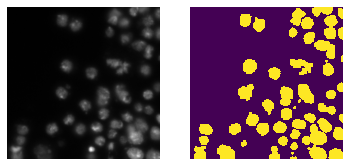

1)
The U-Net architecture is a CNN designed for segmentation tasks. The architecture is characterized by a U-shaped structure, consisting of a contracting path (encoder) on the left and an expansive path (decoder) on the right, with skip connections linking corresponding layers between the two paths.
The encoder captures features through convolutional and pooling layers, reducing spatial dimensions. Skip connections allow the network to maintain high-resolution information by directly linking the encoder and decoder. This information can be accessed to skip convolutions and poolings to reduce computational time. It also helps overcoming the vanishing gradient problem during backpropagation.

2)
- FCN (Fully Convolutional Network): Transforms any CNN into a fully convolutional network, enabling pixel-wise predictions. It uses upsampling layers to restore the spatial dimensions.
- PSPNet (Pyramid Scene Parsing Network): Employs a pyramid pooling module to capture contextual information at multiple scales.
- DeepLab Series: Utilizes atrous/dialated convolutions to capture multi-scale contextual information. DeepLabv3, for instance, combines dilated convolutions with atrous spatial pyramid pooling.
3)
Purpose of Skip Connections in U-Net:

Gradient Flow and Feature Reuse: Skip connections facilitate the flow of gradients during backpropagation, addressing the vanishing gradient problem. This aids in training deep networks.

Preservation of Spatial Information: High-resolution information from the encoder path is directly transferred to the decoder path, preserving fine details and spatial context.

Reduction of Boundary Artifacts (undesired effects or distortions that may occur near the boundaries of segmented objects): By concatenating feature maps from the encoder to the decoder, U-Net reduces the amount of boundary artifacts that may arise due to the use of SAME convolutions.

Effect on Training: Skip connections enable the network to learn both global and local features, combining contextual information with detailed spatial information. The direct connection paths help in recovering precise object boundaries in the segmentation task.



In [16]:
# TODO Implement the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """
        Initialize the U-Net architecture.

        Args:
        - in_channels (int): Number of input channels (e.g., 1 for grayscale, 3 for RGB images).
        - out_channels (int): Number of output channels (e.g., 1 for binary segmentation, >1 for multi-class segmentation).
        """
        super(UNet, self).__init__()
        
        # Encoder blocks: progressively reduce spatial dimensions and extract features
        self.encoder1 = self.conv_block(in_channels, 64)  # First layer, input to 64 channels
        self.encoder2 = self.conv_block(64, 128)  # Second layer, 64 to 128 channels
        self.encoder3 = self.conv_block(128, 256)  # Third layer, 128 to 256 channels
        self.encoder4 = self.conv_block(256, 512)  # Fourth layer, 256 to 512 channels
        
        # Bottleneck: the bottom of the "U", with the highest feature dimension
        self.bottleneck = self.conv_block(512, 1024)  # Bottleneck layer, 512 to 1024 channels
        
        # Decoder blocks: progressively increase spatial dimensions and combine features
        # Upsampling (via transposed convolution) and convolutional decoding
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # Upsample from 1024 to 512
        self.decoder4 = self.conv_block(1024, 512)  # Combine upsampled features with encoder features
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample from 512 to 256
        self.decoder3 = self.conv_block(512, 256)  # Combine upsampled features with encoder features
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample from 256 to 128
        self.decoder2 = self.conv_block(256, 128)  # Combine upsampled features with encoder features
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample from 128 to 64
        self.decoder1 = self.conv_block(128, 64)  # Combine upsampled features with encoder features
        
        # Final output layer: reduce to the number of desired output channels (e.g., 1 for binary segmentation)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """
        Create a block of two convolutional layers with ReLU activation.

        Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.

        Returns:
        - nn.Sequential: A sequential container of convolutional layers and activations.
        """
        return nn.Sequential(
            # padding = 1 means the spatial dimensions remain the same, unlike in the original implementation, hence we do not need to crop feature maps
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # First convolution
            nn.ReLU(inplace=True),  # ReLU activation for non-linearity
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Second convolution
            nn.ReLU(inplace=True)  # ReLU activation for non-linearity
        )
    
    def forward(self, x):
        """
        Forward pass through the U-Net architecture.

        Args:
        - x (torch.Tensor): Input image tensor with shape (batch_size, in_channels, height, width).

        Returns:
        - torch.Tensor: Segmentation output with shape (batch_size, out_channels, height, width).
        """

        # nn.MaxPool2d(2) is a callable object -> can be called like a function, nn.MaxPool2d(2)(enc1) shorthand for doing maxpooling on enc1
        # Encoder path
        enc1 = self.encoder1(x)  # First encoder block
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))  # Max-pooling + second encoder block
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))  # Max-pooling + third encoder block
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))  # Max-pooling + fourth encoder block
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))  # Max-pooling + bottleneck layer
        
        # Decoder path
        # combine high-resolution features from the encoder with upsampled features from the decoder (skip connection)
        # torch.cat concatenates the upsampled feature map (dec4) with the corresponding encoder feature map (enc4) along the channel dimension (dim=1)
        dec4 = self.upconv4(bottleneck)  # Upsample bottleneck output
        dec4 = self.decoder4(torch.cat([dec4, enc4], dim=1))  # Concatenate with encoder4 output
        
        dec3 = self.upconv3(dec4)  # Upsample
        dec3 = self.decoder3(torch.cat([dec3, enc3], dim=1))  # Concatenate with encoder3 output
        
        dec2 = self.upconv2(dec3)  # Upsample
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))  # Concatenate with encoder2 output
        
        dec1 = self.upconv1(dec2)  # Upsample
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))  # Concatenate with encoder1 output
        
        # Final output layer
        out = self.out_conv(dec1)  # 1x1 convolution to get desired output channels
        return out

In [17]:
# TODO Instantiate a unet and check that your architecture is correct by applying it to
# an input from the train loader
model = UNet()
model.to(device)

UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Con

In [18]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Check the architecture by applying it to a sample input
for inputs, labels in train_loader:
    # Move inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Perform a forward pass
    outputs = model(inputs)
    
    # Print shapes
    print("Input shape: ", inputs.shape)   # Should be (1, in_channels, height, width)
    print("Output shape:", outputs.shape) # Should match (1, out_channels, height, width)
    
    # Break after the first batch
    break

Input shape:  torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


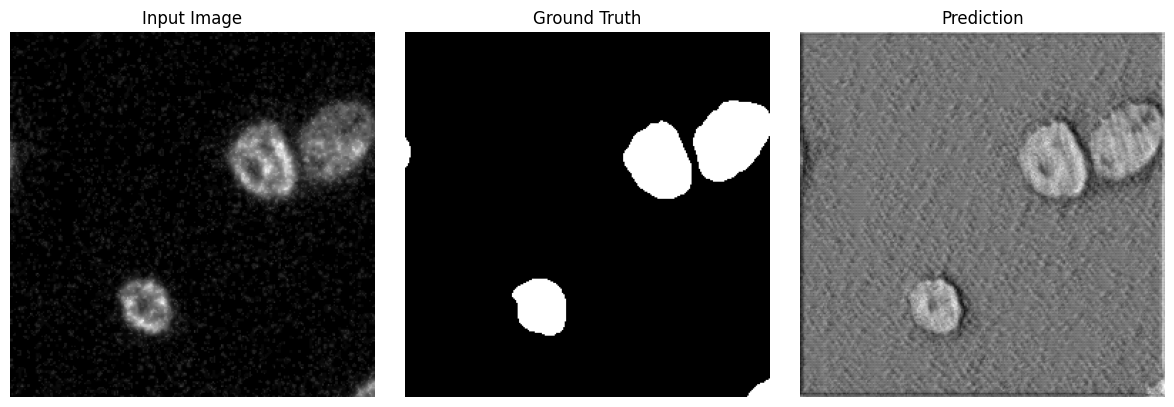

In [19]:
# TODO Display the prediction. Can you interpret the resulting image?

# Move tensors to CPU for visualization
input_image = inputs[0].cpu().squeeze().numpy()       # First input image
ground_truth = labels[0].cpu().squeeze().numpy()      # First ground truth label
prediction = outputs[0].cpu().squeeze().detach().numpy()  # First prediction

# Create a figure to display the images
plt.figure(figsize=(12, 4))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.axis('off')

# Display the ground truth label
plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# Display the model's prediction
plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Prediction")
plt.axis('off')

# Show the figure
plt.tight_layout()
plt.show()

#### Interpretation of the images: 

- input image is a grayscale image of nuclei, brighter spots are areas of interest
- ground truth is the label provided by the dataset, which represents the correct segmentation
    - White areas correspond to the nuclei the model is supposed to detect
    - Black areas correspond to the background
- The prediction is the output of the U-Net model:
    - probability map where each pixel value indicates the likelihood of belonging to the object (nuclei)
    - The bright spots in the prediction correspond to areas where the model is confident that a nucleus is present
    - The darker areas in the prediction correspond to areas identified as the background
    - prediction is a soft probability map (grayscale)
        - Bright regions → High confidence for the presence of an object
        - Dim regions → Low confidence or uncertainty
     
=> U-Net model is untrained (i.e., it hasn't undergone gradient updates to learn from the data), its weights are initialized randomly, hence the obvious pad prediction

## Training
Now we can define the training functions, similar to the last exercises but adapted for segmentation, and then plot the results of loss and metrics.

## Discussion:
Another way to monitor the loss, metrics and images during training and validation is [tensorboard](https://www.tensorflow.org/tensorboard). Note that usually the data for tensorboard is stored separately from the notebook files/scripts, so if you copy the scripts somewhere else you will not see the curves in tensorboard anymore.

In [20]:
# In this cell all the training and validation functions are implemented for you already;
# these implementations are fairly similar to the exercise where we trained a CNN on CIFAR

# Normalize a tensor to range [0, 1] (per channel).
# This is needed to properly display the tensor as an image.
def normalize(tensor):
    eps = 1e-6
    normed = tensor.numpy()
    minval = normed.min(axis=(0, 2, 3), keepdims=True)
    normed = normed - minval
    maxval = normed.max(axis=(0, 2, 3), keepdims=True)
    normed = normed / (maxval + eps)
    return torch.from_numpy(normed)


# Train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# Validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# Run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)

        # Save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

    return train_losses, train_accs, val_losses, val_accs


# Plot the metrics
def plot(
    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None
):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training " + label.lower(), "Validation " + label.lower()

    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']

    if extra_pt:
        plt.plot(*extra_pt, 'ok')

    if extra_pt_label:
        legend.append(extra_pt_label)

    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)

    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')

    plt.show()

We will use (per-pixel) binary cross entropy as a loss function. Pytorch offers to different implementations of this loss: [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

HINTS:
- The targets for BCE should be 'float32' values

QUESTIONS:
- What is the difference between the two different implementations?
- Which one do we need to use here, and why?

The main difference between BCELoss and BCEWithLogitsLoss lies in their input expectations and activation:

- BCELoss expects raw, unnormalized scores (logits) and applies the sigmoid activation function internally (inside the loss function, not before!). This runs into problems in terms of numerical stability since log(0) is undefined but converges to -inf for positive values very close to 0 (implementation substitutes it with -100). with BCE loss we would also need to explicitly apply the sigmoid function inside of our model, before computing the loss. This is not integrated in our implementation of the U-Net.

- BCEWithLogitsLoss expects logits directly, without applying the sigmoid activation. It combines the sigmoid activation and binary cross-entropy loss in a numerically stable way that avoids the problem with log(0). Using BCEWithLogitsLoss is often preferred, as it can be more stable during training and avoids potential numerical issues when dealing with extremely large or small values (0 1). 

For this U-Net architecture, we should use BCEWithLogitsLoss because the final layer in the model is not designed with an activation function. The raw output of the model is then passed to BCEWithLogitsLoss, which internally handles both the sigmoid activation and binary cross-entropy loss.

In [21]:
# TODO create the loss function
loss = nn.BCEWithLogitsLoss()

Next, we want to define a suitable metric for measuring the quality of the (binary) network prediction. We will use the [dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for this, which compares the intersection of prediction and target to their union.

In [22]:
# TODO implement the dice score as a function.
# HINTS:
# - for later parts of this exercises, you should implement it in such a way that
# the function can compute the dice score for input and target with multiple channels,
# and so that it is computed independently per channel and the channel average is returned
# - since we don't have an activation in the U-Net you need to bring the predictions in range [0, 1] using torch.sigmoid
# - the dice score can be formulated for continuous predictions in [0, 1]; you do not need to threshold the predictions
# Hint: You can write a separate function to flatten data and use it in your dice_score function
import torch

def flatten_per_channel(tensor):
    """
    Flattens a multi-channel tensor into a 2D tensor for per-channel operations.
    
    Parameters:
    - tensor (torch.Tensor): Input tensor of shape (N, C, H, W) where:
        N = batch size,
        C = number of channels,
        H = height,
        W = width.

    Returns:
    - torch.Tensor: Flattened tensor of shape (C, N * H * W).
    """
    # Get the number of channels (C)
    num_channels = tensor.size(1)  # Tensor shape: (N, C, H, W)
    
    # Permute dimensions to bring the channel axis to the front
    # From (N, C, H, W) to (C, N, H, W)
    permuted = tensor.permute(1, 0, 2, 3).contiguous()
    
    # Flatten all dimensions except the channel dimension
    # From (C, N, H, W) to (C, N * H * W)
    flattened = permuted.view(num_channels, -1)
    
    return flattened


def dice_score(input_, target, eps=1e-7):
    """
    Compute the Dice Score for multi-channel input and target.

    Parameters:
    - input_ (torch.Tensor): Predicted segmentation map of shape (N, C, H, W).
    - target (torch.Tensor): Ground truth segmentation map of shape (N, C, H, W).
    - eps (float): Small epsilon to avoid division by zero.

    Returns:
    - float: Average Dice Score across all channels.
    """
    # Ensure input and target have the same shape
    assert input_.shape == target.shape, f"Shape mismatch: {input_.shape}, {target.shape}"
    
    # Step 1: Apply sigmoid activation to bring predictions into [0, 1]
    input_ = torch.sigmoid(input_)
    
    # Step 2: Flatten input and target for per-channel Dice computation
    input_flat = flatten_per_channel(input_)  # Shape: (C, N * H * W)
    target_flat = flatten_per_channel(target)  # Shape: (C, N * H * W)
    
    # Step 3: Compute the numerator (intersection) for each channel
    # Intersection is the element-wise product summed over the flattened spatial dimensions
    intersection = torch.sum(input_flat * target_flat, dim=-1)  # Shape: (C,)
    
    # Step 4: Compute the denominator (sum of input and target areas) for each channel
    # Denominator includes the "union-like" terms: sum of squares of both input and target
    input_sum = torch.sum(input_flat * input_flat, dim=-1)  # Shape: (C,)
    target_sum = torch.sum(target_flat * target_flat, dim=-1)  # Shape: (C,)
    denominator = input_sum + target_sum  # Shape: (C,)
    
    # Step 5: Compute the Dice Score for each channel
    # Dice = 2 * (intersection / union), where union is the denominator
    channelwise_dice = 2.0 * intersection / (denominator + eps)  # Shape: (C,)
    
    # Step 6: Average the Dice Score across all channels
    average_dice = channelwise_dice.mean()  # Scalar: average over all channels
    
    return average_dice #=>overlap between predicted and ground truth masks.


In [23]:
# TODO Check your dice implementation for an example model prediction and the corresponding target
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
model.eval()

# Get a batch of data from the validation loader
for inputs, targets in val_loader:

    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass to get model predictions
    with torch.no_grad():
        predictions = model(inputs)

    # Compute the Dice Score
    dice = dice_score(predictions, targets)

    # Print the Dice Score
    print(f'Dice Score: {dice}')

    break  # Break after processing one batch

Dice Score: 0.5448265671730042


100%|██████████| 10/10 [02:35<00:00, 15.54s/it]


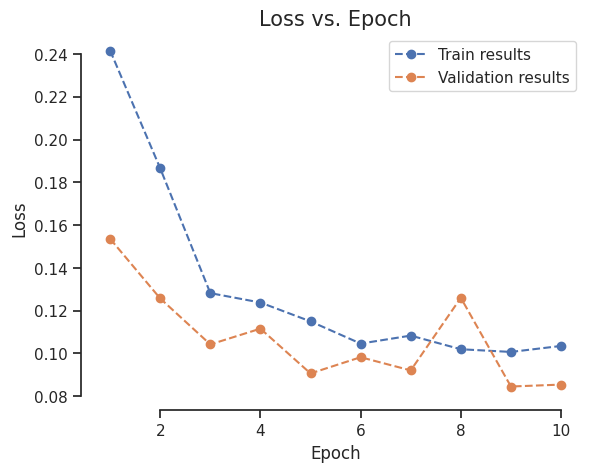

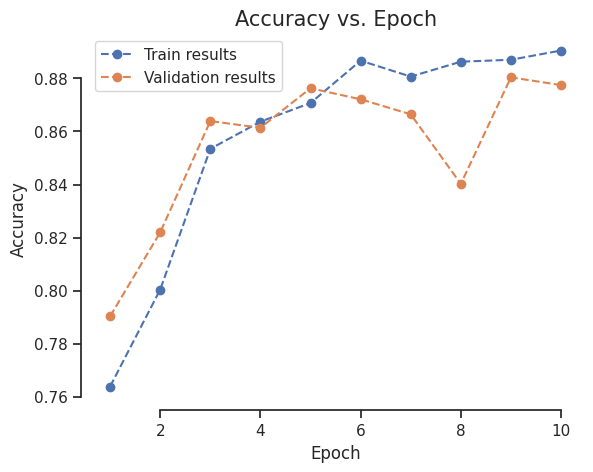

In [24]:
# Train the model for 10 epochs,
# after the training, check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = dice_score
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

## Evaluate on test data

Now, we will evaluate the **instance segmentation**  derived from the model predictions on the test data. To this end, we will use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)#Algorithms) to convert the (binarized) network predictions into an instance segmentation. We will use the implementation from [skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label).

**QUESTION**:
- Describe briefly what the connected components algorithm does when applied to a (binary) image. (You don't need to comment on the implementation).

Since U-Net performs semantic segmentation, converting its binary output into instance segmentation requires post-processing.

we use connected components for that: 

The connected components algorithm labels each connected region of foreground pixels with a unique identifier. Connected components are sets of neighbouring pixels with the same value (in this case, foreground pixels with a value of 1). The algorithm passes over the binary image and assigns a label to each connected component (here all the pixels of a single nucleus), allowing for the identification and distinction of individual regions/objects in the image.

In [25]:
# TODO Load and normalize the test images
test_image_paths = glob(os.path.join(data_folder, "test", "images", "*.tif"))
test_image_paths.sort()

test_mask_paths = glob(os.path.join(data_folder, "test", "masks", "*.tif"))
test_mask_paths.sort()

assert len(test_image_paths) == len(test_mask_paths)

test_images = [imageio.imread(path) for path in test_image_paths]
test_masks = [imageio.imread(path) for path in test_mask_paths]

ims_flat = np.concatenate([im.ravel() for im in test_images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
test_images = [(im.astype("float32") - mean) / std for im in test_images]

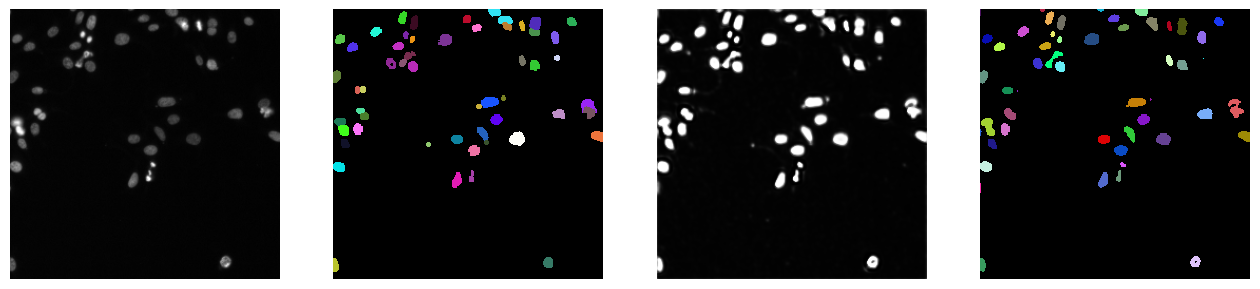

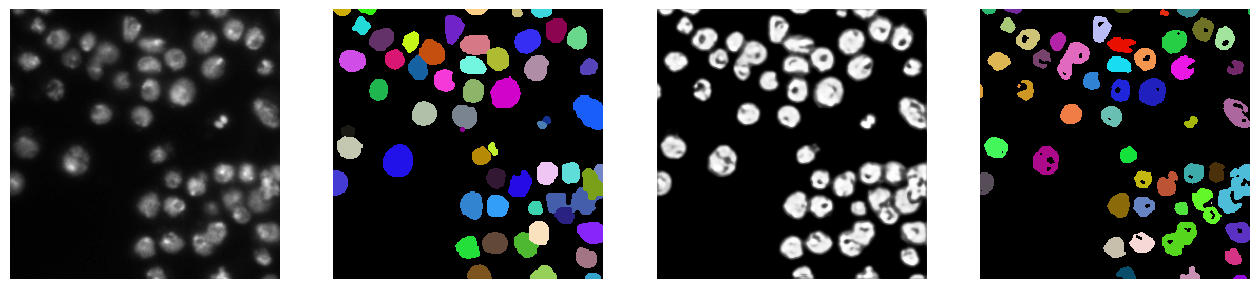

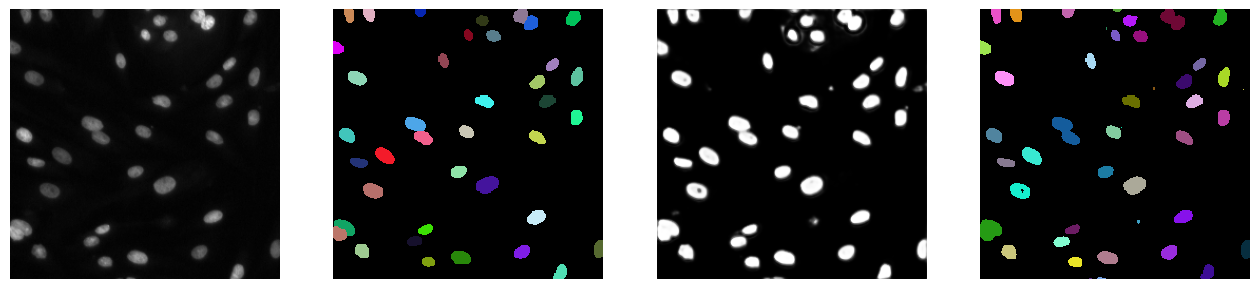

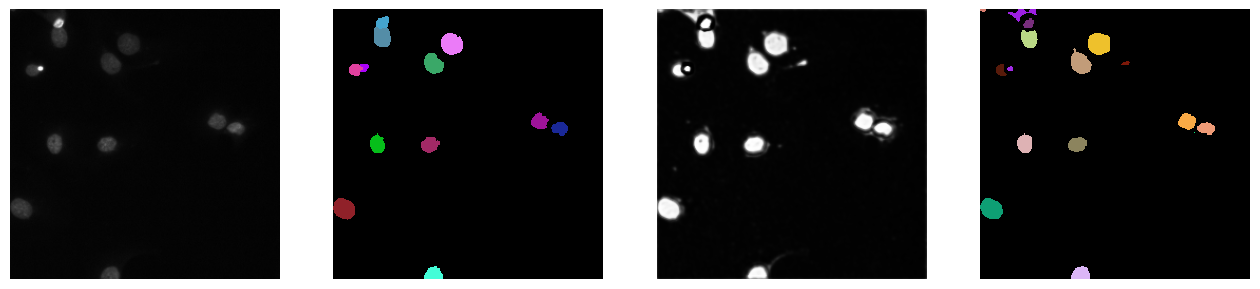

In [26]:
# Check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break

        # Predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()

        # Get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label(pred > 0.5) # label() is the connected components algo
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))

        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")

        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")

        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")

        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")

        plt.show()

        counter += 1

To measure the segmentation quality we compute the intersection over union of each object in the prediction and each object in the ground-truth (if they overlap at all). We then find the best match between ground-truth and predicted objects and count all best matches above a given threshold (here 0.5) as true positives (TP). The objects in the the ground-truth that do not have a match are counted as false negatives (FN), the objects in the prediction that do not have a match as false positives (FP).

We can then compute the F1-Score based on TP, FP and FN and use it as evaluation criterion to compare the quality of instance segmentation results.
For segmentation, a good F1-score is typically above 0.9 for clean datasets, though 0.7–0.8 may suffice for challenging cases. 

In [27]:
# Compute f1 score based on true positives, false positives and false negatives
def f1(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


# Compute the matches between predicted object (seg) and ground-truth objects (mask)
def compute_scores(seg, mask):
    # The contingency table function computes the overlap (intersection) between all objects in the two segmentations
    overlap = contingency_table(seg, mask).toarray()

    # Compute the total number of pixels for each object
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)

    # Normalize the overlap by the union to compute the IOU
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)

    # Ignore matches with zero (= background)
    ious = ious[1:, 1:]

    # Compute the number of true objects (in mask), predicted object (in seg)
    # and the maximal number of matches (minimum of the too)
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious


# Compute the true positives (= matches with a iou bigger than the threshold)
def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # Compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0

    return tp


# Compute the f1 score between predicted (seg) and ground-truth (mask) objects for the given threshold
def f1_score(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0

    n_true, n_matched, n_pred, scores = compute_scores(seg, mask)
    tp = compute_tps(scores, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    return f1(tp, fp, fn)

In [28]:
# Compute the average f1 score of all the test images
f1s = []
model.eval()

with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # The model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(slice(0, -(sh%16)) for sh in im.shape)
            im = im[crop]
            mask = mask[crop]

        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        labels = label(pred > 0.5)

        f1s.append(f1_score(labels, mask))

print()
print("Mean f1 score:", np.mean(f1s))

100%|██████████| 50/50 [00:01<00:00, 33.36it/s]


Mean f1 score: 0.6137328078326783


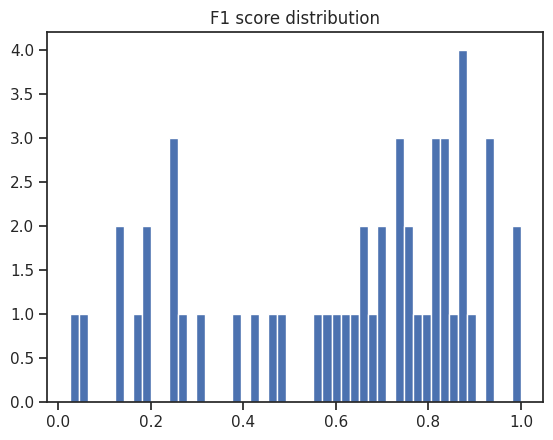

In [29]:
# Plot distribution of scores
plt.hist(f1s, bins = len(f1s))
plt.title('F1 score distribution')
plt.show()

**QUESTION**:
- Based on the examples you have visualized above, what are the biggest sources of error in the model predictions (instance segmentation)?
- How could these errors be addressed?

There are mainly 2 problems that can be identified looking at our example plots

- Overlapping instances: We can observe that the model struggles with images that contain overlapping nuclei and segments them as a single nucleus. This problem could be solved by introducing boundaries to our model.
- Imperfect segmentation within nuclei: We can also observe that the model struggles with images that include nuclei with dark spots within. The model is capable to detect that the area in the picture is a nuclei, but classifies the dark spots within as not belonging to the nuclei. This is undesired behaviour because we would like to classify all pixels that belong to nuclei as such.

Both these issues can be tackled by intorducing a boundary to our prediction, to predict if a pixel belong to a nuclei or not or if it is between nuclei or a nuclei and nothing else.

## Train with boundary channel
To avoid merges of touching nuclei, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [30]:
# TODO Implement a transform that outputs an image with 3 values:
# 0 for backgorund, 1 for foreground (= nucleus) and 2 for boundary (boundary pixel between nucleus and background or between 2 nuclei)
# HINT: You can use skimage.segmentation.find_boundaries (already imported) to determine the boundary pixels
def label_transform(mask):
    ...

In [31]:
# Instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset(train_images, train_masks, mask_transform=label_transform)
val_dataset = NucleiDataset(val_images, val_masks, mask_transform=label_transform)

TypeError: Image data of dtype object cannot be converted to float

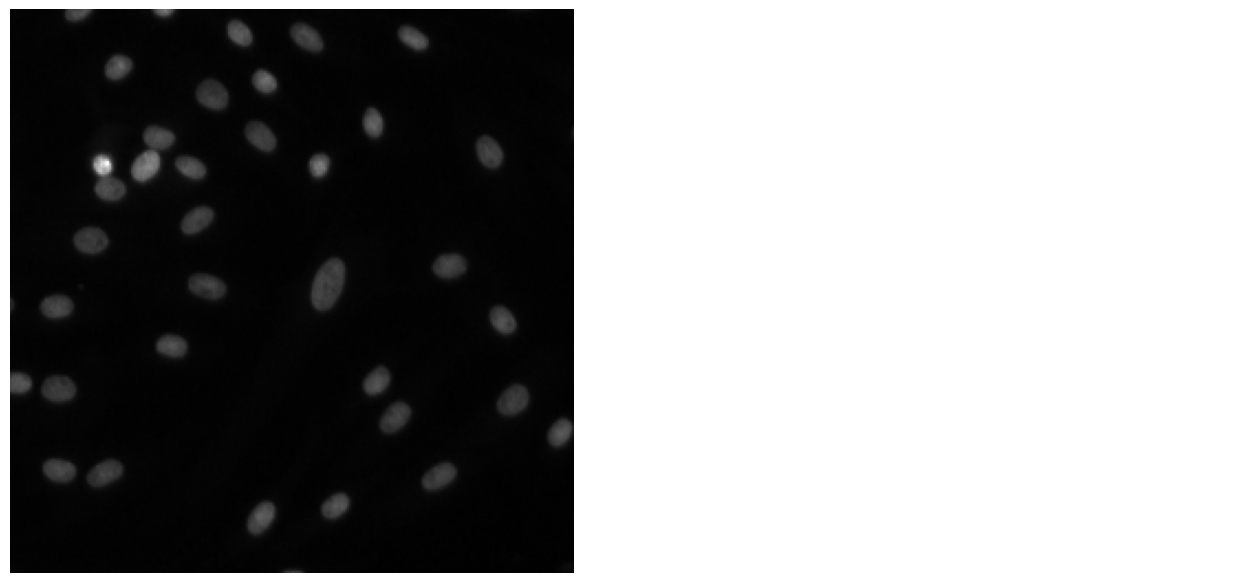

In [32]:
# Visualize the new label transform and make sure it's correct
counter = 0
for im, target in train_dataset:
    if counter > 3:
        break

    fig, ax = plt.subplots(1, 2, figsize=(16, 16))

    ax[0].axis("off")
    ax[0].imshow(im[0], cmap="gray")

    ax[1].axis("off")
    ax[1].imshow(target)

    plt.show()
    counter += 1

In [ ]:
# TODO Instantiate the new unet and loss function
model =
loss =

In [ ]:
# Train the new U-Net for 10 epochs
# (we don't use a metric here, since the target (with class labels 0, 1, 2) and prediction (one-hot encoding) have different representations
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None
train_losses, _, val_losses, _ = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)

**Instance segmentation via watershed:**
We now want to use the predictions for background, foreground and boundary to better separate the nuclei than before using the following approach:
- Subtract the boundary prediction from the foreground prediction to separate touching nuclei from each other.
- Apply connected components to the result to get the "core" of the now separated nuclei.
- Grow these nucleus cores back to the full outlines.
    - For this step we will use the watershed algorithm, which segments images based on a height-map and markers.
    - The markers define the core of regions and they are grown by this algorithm until two markers meet at the highest point between them (defined by the heightmap).
- We will restrict the watershed to the foreground, so that nuclei don't spill over into the background.

**Let's visualize these steps to better understand them:**
- We are given the foreground and boundary predictions from the model:

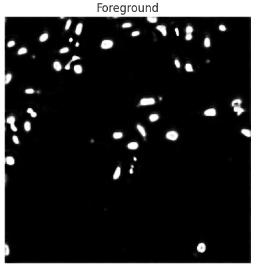 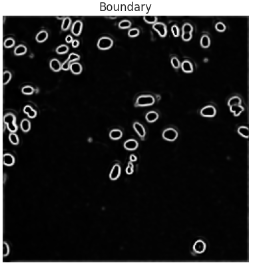

- Subtract the boundaries from the foreground predictions (left image), threshold the result (not shown) and apply connected components to generate the markers (right image):

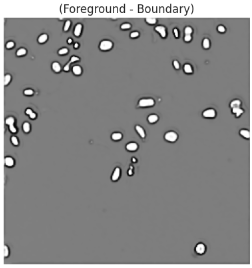

- This provides us with all three inputs for the watershed:
    - The boundary predictions from the network can be used as heightmap (because they separate the nuclei) (*left image*)
    - The markers that we have just computed (*middle image*)
    - The thresholded foreground predictions, which we use as mask for the watershed (*right image*)

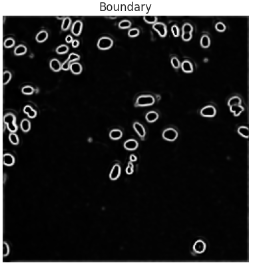 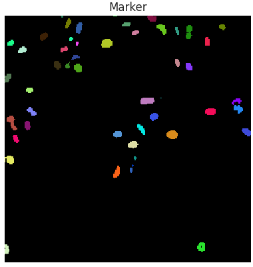 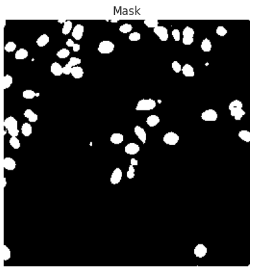

**Implementing the watershed:**
You can use `skimage.segmentation.watershed` (already imported) for this.
Here's how to use it:

```python
from skimage.segmentation import watershed

boundaries = ...
markers = ...
mask = ...

segmentation = watershed(image=boundaries, markers=markers, mask=mask)
```
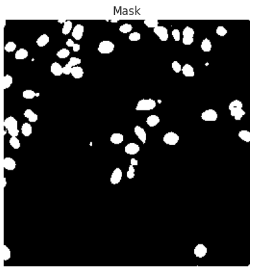
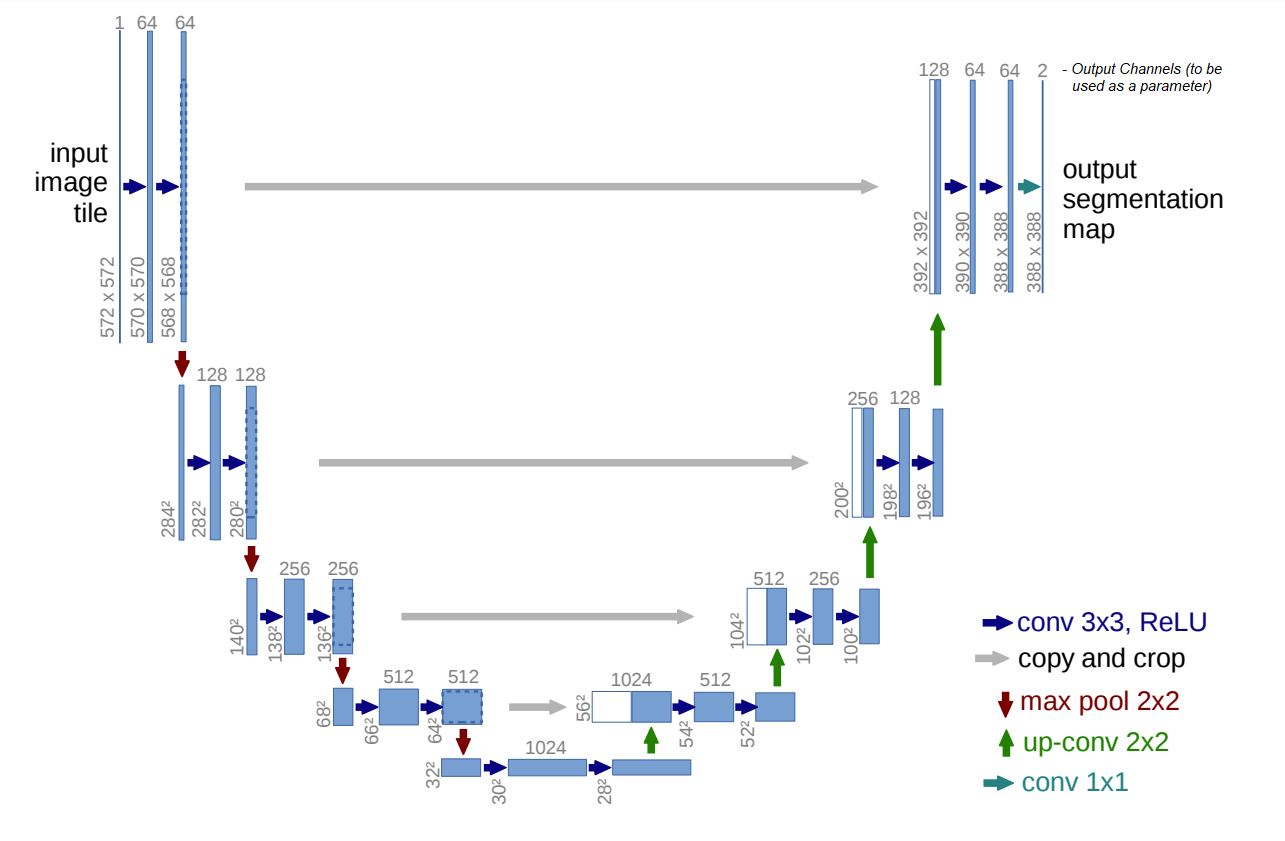

In [ ]:
# TODO Implement the watershed approach described above.
# Hint: To obtain the foreground_seeds you neet to threshold the foreground and boundary to create a binary mask
def instance_segmentation(foreground_prediction, boundary_prediction, threshold=0.5):
    ...

In [ ]:
# TODO Check the prediction results and instance segmentation for a few images
# Make sure your instance segmentation implementation is correct
# HINT: You need to apply a softmax to the network predictions

In [ ]:
# TODO Use the validation set to find a good value for the 'threshold' parameter in the instance_segmentation function
best_threshold =

In [ ]:
# Compute the average f1 score of all the test images
f1s = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(slice(0, -(sh%16)) for sh in im.shape)
            im = im[crop]
            mask = mask[crop]

        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()

        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])

        f1s.append(f1_score(nuclei, mask, best_threshold))

print()
print("Mean f1 score:", np.mean(f1s))

**QUESTIONS**:
- Did training with the boundaries and using them in the instance segmentation improve the results?
- Can you think of ways to improve the loss function for this learning task?

**TODO** your answers here

## Use the dice coefficient as loss function
Since our target is quite unbalanced (in particular the boundary channel), it is beneficial to use a loss function that is robust against class imbalance. In this part of the exercise we will use the Dice coefficient as loss. We have already used it as a metric before.

Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [ ]:
# TODO Implement a loss function based on the dice coefficient
# HINT: The dice coefficient is in range [0, 1] and higher values correspond to a better result
# Loss functions are minimized, so lower values should correspond to a better result

In [ ]:
# TODO Implement and compare with different loss function variations

**QUESTIONS**:
- Did training with dice loss improve the results? Comment on it!

TODO your answers here

## Try variations of the UNet architecture (*Optional*)
- add BatchNorm
- replace TransposedConvs with bilinear upsampling and 1x1 convs
- use residual blocks instead of the normal convolutional blocks

In [ ]:
# TODO (Optional) Implement and compare u-net architecture variations

## Train with data augmentation (*Optional*)
- rotations & flips
- noise augmentations (add gaussian noise and/or poisson noise)
- crop and resize

Hint: use the `image_transform` (noise augmentations) and `transform` (geometrical augmentations) argument of the `NucleiDataset`

In [ ]:
# TODO (Optional) implement data augmentations and compare with training without augmentations

# Denoising with Noise2Noise
Here, we implement [Noise2Noise](https://arxiv.org/abs/1803.04189), which is a method to learn image denoising **without** ground-truth, by using a different noisy image as target. Note that we are re-using the same architecture as before, which is a bit different from the one used in the paper.
In order to evaluate the performance of segmentation and denoising, different metrics are used. For denoising, a PSNR of ~30 dB or higher indicates high-quality results for near noise-free RGB images.

## Data Preparation
We use the [VSDR dataset](https://cv.snu.ac.kr/research/VDSR), which contains 'clean' (i.e. without noise) natural images.

In [ ]:
# Download the VSDR data
!conda install -y gdown
!gdown --id 1hNB5_MkxutrKLa1g35tSLCiq1J5xxH9F --folder

os.makedirs("/kaggle/working/dlforcv-ex4", exist_ok=True)

!unzip "/kaggle/working/VDSR/train_data.zip" -d "dlforcv-ex4/vsdr_train"
!unzip "/kaggle/working/VDSR/test_data.zip" -d "dlforcv-ex4/vsdr_test"

In [ ]:
# Setting paths for the training and testing data
vsdr_train = "/kaggle/working/dlforcv-ex4/vsdr_train/"
vsdr_test = "/kaggle/working/dlforcv-ex4/vsdr_test/"

In [ ]:
# Check the unique image sizes in the training data
image_exts = (".jpeg", ".jpg", ".png", ".bmp")
all_image_paths = [
    p for p in Path(vsdr_test).glob("**/*") if p.suffix.lower() in image_exts
]

shapes = []
for p in all_image_paths:
    shapes.append(imageio.imread(p).shape)

unique_shapes = list(set(shapes))
print(unique_shapes)

In [ ]:
# vsdr dataset that can deal with all the different data sizes in the training and test data
class VsdrDataset(Dataset):
    def __init__(self, root_dir, noise_transform):
        image_exts = (".jpeg", ".jpg", ".png", ".bmp")
        self.image_paths = [
            p for p in Path(root_dir).glob("**/*") if p.suffix.lower() in image_exts
        ]
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        im = np.array(imageio.imread(self.image_paths[index]))
        if im.ndim == 2:
            im = np.concatenate([im[..., None]] * 3, axis=2)

        if im.shape[-1] == 1:
            im = np.concatenate([im] * 3, axis=2)

        target_shape = (256, 256)

        # First, pad the images if they are smaller than the target crop shape
        if any(sh < tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            padding = tuple((0, tsh - sh if sh < tsh else 0) for sh, tsh in zip(im.shape[:-1], target_shape))
            padding = padding + ((0, 0),)
            im = np.pad(im, padding, mode="reflect")

        # Then crop tham if they are too large
        if any(sh > tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            crop_start = [np.random.randint(0, sh - tsh) if sh != tsh else 0 for sh, tsh in zip(im.shape[:-1], target_shape)]
            crop = tuple(slice(cs, cs + tsh) for cs, tsh in zip(crop_start, target_shape))
            im = im[crop]

        assert im.shape == (256, 256, 3), f"{im.shape}"

        # Normalize the image to range [0, 1] (per channel)
        im = im.astype("float32")
        im -= im.min(axis=(0, 1), keepdims=True)
        im /= im.max(axis=(0, 1), keepdims=True)

        # Bring image in range [-1, 1]
        im = 2 * im - 1

        # Transform to channel first order
        im = im.transpose((2, 0, 1))

        # Apply the noise transformation
        return self.noise_transform(im)

In [ ]:
# Go from range [-1, 1] to [0, 255] and uint8
# and go to channel last order
def to_display(im):
    im = (((im + 1) / 2) * 255).astype("uint8")
    return im.transpose((1, 2, 0))

In [ ]:
# Sample a few images
check_dataset = VsdrDataset(vsdr_train, lambda x: x)
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for ii in range(16):
    im = check_dataset[ii]
    ax[ii % 4, ii // 4].axis("off")
    ax[ii % 4, ii // 4].imshow(to_display(im))

plt.show()

## Train a network with clean targets
As the first baseline, we will train a network with clean target data (i.e. without noise added to it).

In [ ]:
# Instatiate the model and loss function (Mean Squared Error)
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# We will use the PSNR (peak signal to noise ratio) as metric to evaluate the predictions.
# You can read up on it and the implementation we are using here:
# https://www.ni.com/en-us/innovations/white-papers/11/peak-signal-to-noise-ratio-as-an-image-quality-metric.html
# (the higher the PSNR, the better)
def to_uint8(im):
    return torch.clamp((im + 0.5) * 255.0 + 0.5, 0, 255).type(torch.uint8)


class PSNR(nn.Module):
    def __call__(self, x, y):
        x, y = to_uint8(x), to_uint8(y)
        x, y = x.detach().cpu().numpy(), y.detach().cpu().numpy()
        return peak_signal_noise_ratio(x, y)

**QUESTION**:
- What does the PSNR metric measure?
- Why is it used instead of 'just' computing the pixel wise error (MSE)?

**TODO** your answer here

In [ ]:
# TODO Implement a function that adds additive gaussian noise to the input
# the var argument should correspond to the variance of the gaussian
# HINT: You can use the function `random_noise` from scikit-image. Don't forget to cast the output as float.
def additive_gaussian_noise(x, var):
    ...

In [ ]:
# TODO Instantiate a vsdr dataset corresponding to the vsdr_train folder
# with a noise transformation that returns a corrupted image (as network input)
# and a clean image (as target)
# use a variance of 0.1
# Split the dataset into a train (90% of the data) and validation dataset (10%)
# HINT: You can use torch.utils.data.random_split to split a torch dataset
vsdr_train_ds =
vsdr_val_ds =

In [ ]:
# Sample a few images from the train dataset
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
for ii in range(3):
    noisy, clean = vsdr_train_ds[ii]

    # Go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))

    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))

plt.show()

In [ ]:
# Train the denoising network
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

In [ ]:
# Create the test dataset
vsdr_test_ds = VsdrDataset(
    vsdr_test,
    noise_transform=lambda x: (additive_gaussian_noise(x, var=0.1), x)
)

In [ ]:
# TODO Display some results on the test data

## Train a network with noisy targets (Gaussian noise)
Now, we train a network from noisy inputs AND noisy targets. And compare its results to the previous denoising network learned on clean targets.

QUESTION:
- Why can the model learn denoising even though we also have a noisy target?

**TODO** your answer here

In [ ]:
# Instantiate new model and loss
model = UNet(in_channels=3, out_channels=3)
model.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# TODO Create dataset with corrupted input and target
# use same variance as before (0.1)
vsdr_train_ds =
vsdr_val_ds =

In [ ]:
# Train the model
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = PSNR()
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

In [ ]:
# TODO Show a few predictions for the test dataset

In [ ]:
# TODO Compute the PSNR for the whole test dataset

**QUESTIONS**:
- Compare the result between the network trained with clean targets and with noisy targets.

**TODO** your answer here

## Train a network with noisy targets (Poisson noise) (*Optional*)
Use poisson noise instead of gaussian noise and compare to both the network trained with clean target and the network with the target corrupted by gaussian noise.

In [ ]:
# TODO (Optional) Run training with poisson noise and compare with previous results